In [1]:
!pip install torch
!pip install torch_geometric
!pip install torch_summary
!pip install networkx
!pip install pennylane-qiskit
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 69.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 68.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.7/340.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 61.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.1 MB/s eta 0:0

In [6]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load your channel gain data (assuming you have it in a CSV file)
df = pd.read_csv('/kaggle/input/weather-dataset/weather-010824-061024.csv', parse_dates=['ts_get'], index_col='ts_get')
heatmap_df = pd.read_csv('/kaggle/input/weather-dataset/weather-010824-061024.csv')

In [7]:
heatmap_df

,id,hum,pres,rain_1h,wind_speed,wind_deg,clouds_all,ts_get,max_temp,min_temp,ave_temp,cod_weather
0,41752,62,1013,0.0,1.54,360,0,2024-08-01 00:00:02,28.21,25.46,27.35,800
1,41753,60,1013,0.0,1.03,0,0,2024-08-01 01:00:01,27.66,24.81,26.85,800
2,41754,66,1013,0.0,1.54,10,0,2024-08-01 02:00:03,27.10,23.81,26.16,800
3,41755,61,1012,0.0,1.03,0,0,2024-08-01 03:00:02,25.97,23.79,24.97,800
4,41756,62,1013,0.0,1.54,50,0,2024-08-01 04:00:03,25.97,22.81,24.87,800
...,...,...,...,...,...,...,...,...,...,...,...,...
1653,43405,87,1013,0.0,3.09,340,20,2024-10-09 03:00:03,18.79,17.08,17.30,801
1654,43406,87,1012,0.0,2.06,340,97,2024-10-09 04:00:02,18.79,17.10,17.48,804
1655,43407,85,1012,0.0,1.03,0,97,2024-10-09 05:00:09,17.10,15.81,17.10,804
1656,43408,85,1013,0.0,1.03,60,0,2024-10-09 06:00:02,17.66,15.81,17.57,800


In [8]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

data = heatmap_df.copy()

data['ts_get'] = pd.to_datetime(data['ts_get'])
data = data.sort_values('ts_get').fillna(method='ffill')

features = ['hum', 'pres', 'rain_1h', 'wind_speed', 'wind_deg', 
            'clouds_all', 'max_temp', 'min_temp', 'ave_temp']
target = 'rain_1h'

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
data[target] = scaler.fit_transform(data[[target]])

def create_windowed_data(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i + window_size].values)
        y.append(data[target].iloc[i + window_size])
    return np.array(X), np.array(y)

X, y = create_windowed_data(data)
train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

/tmp/ipykernel_30/872775709.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('ts_get').fillna(method='ffill')


Training data shape: (1307, 24, 9), Testing data shape: (327, 24, 9)


# 1. Refined Hybrid Quantum-Classical Architecture for Hourly Rainfall Prediction
Since the dataset only contains temporal data from one station, the problem shifts to time-series forecasting. In this case, we model the hourly weather patterns as a dynamic graph, with each hour or day treated as a node connected by temporal edges.

## Data Preprocessing
#### Weather Variables: Collect all relevant features like:
Temperature, humidity, pressure, wind speed, and rainfall status.
#### Graph Construction:
Nodes: Each node represents a time step (e.g., each hour or day).
Edges: Create directed temporal edges between consecutive time steps.
Weighted Edges: Use feature similarity between consecutive hours (e.g., Pearson correlation) as weights.
Node Features: Each node holds a vector of weather attributes for that time step.
#### Example: For hour t, a node might contain [temperature(t), humidity(t), pressure(t), rainfall(t)].

## Hybrid Quantum-Classical Model Design
### Step A: Classical Graph Neural Network Layer (Temporal GNN)
Model type: Use a Temporal Graph Network (TGN) or a Time-Dependent Graph Attention Network (TGAT).
Purpose: Model sequential dependencies between time steps (hours or days).
The TGN will aggregate temporal node embeddings using historical weather data up to the current hour to predict rainfall in the next time step.
### Step B: Quantum Circuit Layer for Feature Embedding
Objective: Enhance node (time-step) embeddings using quantum feature encoding to extract complex correlations.

### Quantum Layer Workflow:

Convert time-step node embeddings (from the GNN) into a quantum state using Amplitude Encoding.
Pass through a parameterized quantum circuit (e.g., variational ansatz).
Extract a quantum-enhanced embedding, which is fed into a classical prediction layer.
Benefit: The quantum circuit helps identify subtle patterns (e.g., non-linear correlations) across multiple weather variables, which can improve prediction accuracy.


## Complete Workflow of the Model
#### Input Layer:
Feed weather data from the past n hours (sliding window approach) into the TGN to create temporal embeddings for each hour.
#### Quantum Layer:
Pass these temporal embeddings through a quantum variational circuit to refine the representation.
#### Prediction Layer:
Use a fully connected classical layer to predict rainfall probability for the next hour.

## Training Procedure
### Hybrid Optimization:
Use backpropagation for the classical layers.
Use parameter-shift rule for the quantum layer's gradients.
Loss Function: Use MSE Loss as it’s a regression task (amount of rainfall).
## Training Strategy:
Use a sliding window approach (e.g., input the past 24 hours of data to predict the 25th hour).
Train-Test Split: Train on 80% of the data, validate on 10%, and test on the remaining 10%.





## 2. Temporal Graph Neural Network (TGN) Implementation
The TGN will learn temporal dependencies by treating each hourly time window as a node. We’ll use Graph Attention Network (GAT) layers to capture dynamic attention between time steps.

## 3. Quantum Circuit for Feature Enhancement
We’ll pass the embeddings from the GNN through a quantum variational circuit to extract subtle patterns. We’ll use PennyLane to design the circuit.

## 4. Hybrid Quantum-Classical Model
We’ll combine the TGN output embeddings with the quantum-enhanced embeddings to improve prediction.

## 5. Training the Hybrid Model
We’ll use MSE Loss for regression and Adam Optimizer for training.

<Axes: >

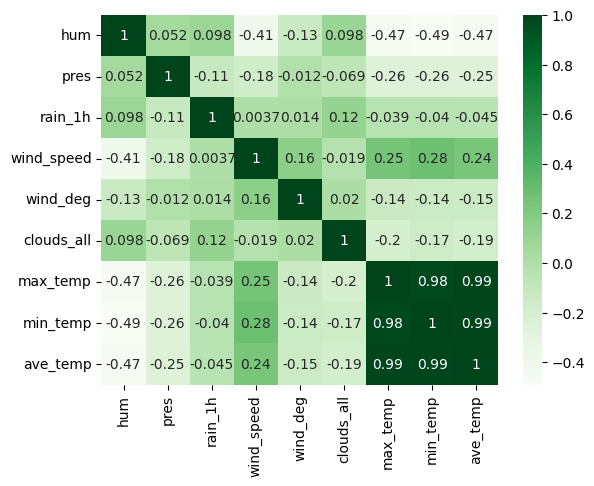

In [6]:
import seaborn as sns
sns.heatmap(heatmap_df.corr(), cmap="Greens", annot=True)

In [7]:
heatmap_df.columns

Index(['hum', 'pres', 'rain_1h', 'wind_speed', 'wind_deg', 'clouds_all',
       'max_temp', 'min_temp', 'ave_temp'],
      dtype='object')

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
import pennylane as qml
import numpy as np

# Set device for Pennylane
dev = qml.device("default.qubit", wires=9)  # Match wires to input features (9)

# Quantum embedding function with AngleEmbedding and reshaped weights
def quantum_embedding(features, weights):
    n_qubits = 9
    n_layers = 3
    weight_shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_qubits)
    weights = weights.reshape(weight_shape)

    @qml.qnode(dev)
    def circuit(features, weights):
        qml.AngleEmbedding(features, wires=range(n_qubits))
        qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return circuit(features, weights)

# Temporal GNN model with GAT layers
class TemporalGNN(nn.Module):
    def __init__(self):
        super(TemporalGNN, self).__init__()
        self.gat1 = GATConv(9, 32, heads=4)
        self.gat2 = GATConv(128, 32, heads=1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.gat2(x, edge_index)
        return self.fc(x)

# Hybrid model that includes the quantum embedding
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.tgn = TemporalGNN()
        self.fc = nn.Linear(10, 1)  # output from TGN + 9 from quantum embedding

        # Initialize quantum weights
        n_layers = 3
        n_qubits = 9
        weight_shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_qubits)
        self.quantum_weights = torch.randn(weight_shape, requires_grad=True)

    def forward(self, x, edge_index):
        # Temporal GNN output
        tgn_output = self.tgn(x, edge_index)

        # Quantum embedding output
        quantum_output = torch.tensor(
            quantum_embedding(x[0].detach().numpy(), self.quantum_weights),
            dtype=torch.float32
        )

        # Concatenate TGN and quantum embedding outputs
        combined = torch.cat([tgn_output[0], quantum_output], dim=-1)
        return self.fc(combined)

# Dynamic graph edge index generator (dummy function for illustration)
def create_dynamic_edge_index(num_nodes):
    edge_index = torch.randint(0, num_nodes, (2, num_nodes))
    return edge_index

# Instantiate model, optimizer, and loss function
hybrid_model = HybridModel()
# Optimizer, Loss, and Scheduler
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_fn = nn.MSELoss()
loss_list = []
val_list = []
for epoch in range(15):
    hybrid_model.train()
    total_loss = 0
    
    for i in range(X_train.shape[0]):  # Process each sample
        optimizer.zero_grad()
        
        x_sample = torch.tensor(X_train[i], dtype=torch.float32)
        edge_index = create_dynamic_edge_index(x_sample.size(0))
        
        # Forward pass
        output = hybrid_model(x_sample, edge_index)
        loss = loss_fn(output.squeeze(), torch.tensor(y_train[i], dtype=torch.float32))
        
        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(hybrid_model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
    
    # Step the scheduler
    scheduler.step()
    
    # Record and print average loss for this epoch
    avg_loss = total_loss / X_train.shape[0]
    loss_list.append(avg_loss)

    hybrid_model.eval()
    with torch.no_grad():
        total_val_loss = 0
        
        for j in range(X_test.shape[0]):
            x_val_sample = torch.tensor(X_test[j], dtype=torch.float32)
            edge_index_val = create_dynamic_edge_index(x_val_sample.size(0))
            val_output = hybrid_model(x_val_sample, edge_index_val)
            val_loss = loss_fn(val_output.squeeze(), torch.tensor(y_test[j], dtype=torch.float32))
            total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / X_test.shape[0]
        val_list.append(avg_val_loss)

        
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Optional: Early stopping based on validation loss could be added here.


Epoch 0, Training Loss: 0.0024, Validation Loss: 0.0065
Epoch 1, Training Loss: 0.0012, Validation Loss: 0.0063
Epoch 2, Training Loss: 0.0012, Validation Loss: 0.0063
Epoch 3, Training Loss: 0.0011, Validation Loss: 0.0060
Epoch 4, Training Loss: 0.0011, Validation Loss: 0.0060
Epoch 5, Training Loss: 0.0011, Validation Loss: 0.0060
Epoch 6, Training Loss: 0.0011, Validation Loss: 0.0059
Epoch 7, Training Loss: 0.0011, Validation Loss: 0.0061
Epoch 8, Training Loss: 0.0011, Validation Loss: 0.0060
Epoch 9, Training Loss: 0.0011, Validation Loss: 0.0060
Epoch 10, Training Loss: 0.0010, Validation Loss: 0.0059
Epoch 11, Training Loss: 0.0010, Validation Loss: 0.0059
Epoch 12, Training Loss: 0.0010, Validation Loss: 0.0059
Epoch 13, Training Loss: 0.0010, Validation Loss: 0.0059


KeyboardInterrupt: 

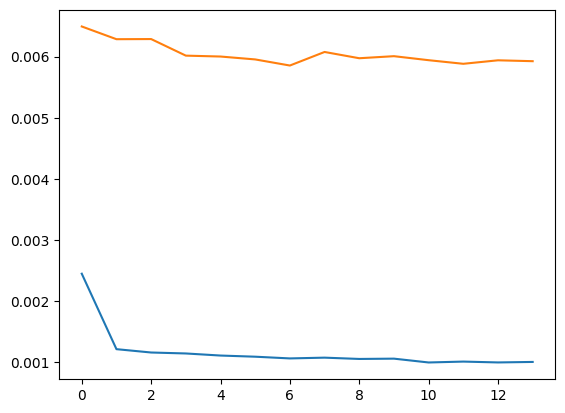

In [68]:
plt.plot(loss_list)
plt.plot(val_list)
plt.show()